# Vizzuality code challenge

This notebook reads and does a small analysis on the [SPAM](https://www.mapspam.info/data/) dataset

## SPAM naming conventions
#### Variables (v)

|||
|------|-------|
|\*\_A_* | physical area|
|\*\_H_* | harvested area|
|\*\_P_* | production|
|\*\_Y_* | yield|
|\*\_V_agg_* | Value of production, aggregated to all crops, food and non-food (see below)|

#### Technologies (T)
|||
|----|----|
|\*\_TA | technologies together, ie complete crop|
|\*\_TI | irrigated portion of crop|
|\_TH | high inputs portion of crop|
|\*\_TL | rainfed low inputs portion of crop|
|\*\_TS | rainfed subsistence portion of crop|
|\*\_TR | rainfed portion of crop (= TA - TI, or TH + TL + TS)|

\* _the .tiff files specify the technology without the T_

In [12]:
from pathlib import Path
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import pandas as pd
import geopandas as gpd

IMAGE_DIRS = [
    "spam2010v2r0_global_phys_area",
    "spam2010v2r0_global_val_prod_agg",
    "spam2010v2r0_global_harv_area",
    "spam2010v2r0_global_prod",
    "spam2010v2r0_global_yield",
]

DATA_BASE_PATH = Path("./data")
CROP_LABEL = "SOYB" # soy beam       

In [13]:
class SpamData:
    def __init__(self, file: Path):
        """ Class that represents a spam raster data set"""
        filename = file.name.split(".")[0]
        self.version, self.region, self.variable, self.crop, self.technology = filename.split("_")        
        

### Data preparation
1. Extract the required images of soy beam
2. Generate the images from the extend defined in `areas.geojson`

In [14]:
soybeam_images = []
for image_dir in IMAGE_DIRS:
    soybeam_images.extend((DATA_BASE_PATH/image_dir).glob(f"*_{CROP_LABEL}_*.tif"))

# should be 24 images for soy beam 
# Note that the value of production aggregated to all crops data is not included.
assert len(soybeam_images) == 24
soybeam_images

[PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_A.tif'),
 PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_H.tif'),
 PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_R.tif'),
 PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_I.tif'),
 PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_S.tif'),
 PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_L.tif'),
 PosixPath('data/spam2010v2r0_global_harv_area/spam2010V2r0_global_H_SOYB_I.tif'),
 PosixPath('data/spam2010v2r0_global_harv_area/spam2010V2r0_global_H_SOYB_S.tif'),
 PosixPath('data/spam2010v2r0_global_harv_area/spam2010V2r0_global_H_SOYB_A.tif'),
 PosixPath('data/spam2010v2r0_global_harv_area/spam2010V2r0_global_H_SOYB_H.tif'),
 PosixPath('data/spam2010v2r0_global_harv_area/spam2010V2r0_global_H_SOYB_R.tif'),
 PosixPath('data/spam2010v2r0_global_harv_area/spam2010V2r0_global_H_SOYB_L.tif'),
 Pos

In [16]:
data = SpamData(soybeam_images[0])

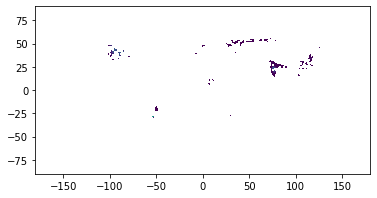

EPSG:4326
epsg:4326


In [9]:
# small check that rasters can be loaded correctly 
with rio.open(soybeam_images[1]) as im:
    show(im)
    raster_crs = im.crs

# load the study areas and check that it has the same crs as the rasters
areas = gpd.read_file(DATA_BASE_PATH/"areas.geojson")
areas["region"] = ["india", "america"]
print(raster_crs)
print(areas.crs)

# assert str(raster_crs).split(":")[1] == str(areas.crs).split(":")[1]

In [10]:
dest_dir = DATA_BASE_PATH/"areas"
dest_dir.mkdir(exist_ok=True)

In [26]:
def make_out_filename(image_path: Path, region: str) -> str:
    name, ext = image_path.name.split(".")
    return f"{name.replace('global', region)}.{ext}"

areas_rasters = []
for im in soybeam_images:
    with rio.open(im) as src:
        # apply mask for each area and save new clipped raster
        for area in areas.itertuples():
            out_image, out_transform = mask(src, shapes=[area.geometry], crop=True)
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })
            
            with rio.open(dest_dir/make_out_filename(im, area.region), "w", **out_meta) as dest:
                dest.write(out_image)
                areas_rasters.append(dest.name)

In [30]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [51]:
with rio.open(areas_rasters[0]) as src:
    box = src.bounds

In [53]:
box.left

70.58233100000001

/home/biel/miniconda3/envs/vizzuality/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


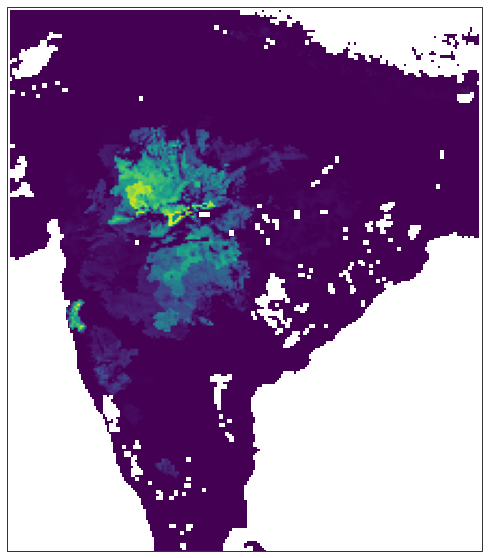

In [68]:

with rio.open(areas_rasters[0]) as src:
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
    #ax.set_extent([-20, 60, -40, 45], crs=ccrs.PlateCarree())
    ax.coastlines(resolution="110m")
    show(src, ax=ax)
    plt.show()
